# CoV sequences distance and visualization

## 1. Data sources
GISAID spike protein seqeunce as of 12/03/2021

## 2. Smith-Waterman Alignment 
The Smith–Waterman algorithm performs local sequence alignment; that is, for determining similar regions between two strings of nucleic acid sequences or protein sequences. Instead of looking at the entire sequence, the Smith–Waterman algorithm compares segments of all possible lengths and optimizes the similarity measure.
  
  Here we use the Python implementation of Needleman-Wunsch algorithm from library scikit-bio. By default, the scoring cost of opening a gap is 5, and extend a gap is 2. The matching scores are according to substitution matrix BLOSUM 50. Another scoring scheme can be each match equals +1, and each mismatch or gap equals -1. 
## 3. Visualization
The pairwise distance for all available sequences are calculated, and visualized by reducing the dimension to 2d using MDS, IsoMap, and tSNE. For a clearer display, species with most samples are separately ploted. 

In [1]:
import random, pickle
import numpy as np
import pandas as pd

from itertools import combinations 
from sklearn.manifold import MDS, Isomap, TSNE, SpectralEmbedding
import matplotlib.pyplot as plt
import seaborn as sns
from visualize import sample_from_dict, process_dict_to_df, calculate_dist_from_df, SW_distance_from_df
import matplotlib.dates as mdates


## Pairwise Smith-Waterman distance with default scoring setting

In [2]:
## add some trainign set data points
gisaid = pd.read_parquet("../data/sampled_for_visual_GISAID1203.parquet")

dms = pd.read_parquet("../data/fitness_embeddings/Seqs_Fitness.parquet", engine='fastparquet').sample(100)

dms['variant'] = 'DMS (Lab)'
dms['date'] = '2019-12-1'
dms['region'] = 'DMS (Lab)'
dms = dms.drop(['strain', 'fitness', 'preference', 'sem_change'], axis=1)
df = pd.concat((dms, gisaid), axis=0, join='inner')
dist = SW_distance_from_df(df, verbose=True)


Smith-Waterman distance 700 / 701Done.


In [3]:
# Date time
dt = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['date'] = dt

df['Date'] = mdates.date2num(dt)

df['Variant'] = df['variant']

# region to Region
try:
    df['Region'] = df["region"]
except KeyError:
    pass

In [4]:
for idx, each in df.iterrows():
    if each['Seqs'].endswith("*"):
        print(each)

## Dimension Reduction

In [5]:
dim_redu = MDS(dissimilarity='precomputed')
xy_mds = dim_redu.fit_transform(dist)

In [6]:
dim_redu = Isomap(metric='precomputed', n_neighbors=10)
xy_iso = dim_redu.fit_transform(dist)

In [7]:
dim_redu = TSNE(metric='precomputed', perplexity=50, n_iter=2000)
xy_tsne = dim_redu.fit_transform(dist)

plt.figure(figsize=(12, 8))
sns.set_palette(sns.color_palette("Spectral"))
plot = sns.scatterplot(x=xy_tsne[:, 0], y=xy_tsne[:, 1], hue=df['Host'])
h,l = plot.axes.get_legend_handles_labels()
plot.axes.legend_.remove()
plot.figure.legend(h,l, ncol=3, bbox_to_anchor=(1.3, 0.8))
plt.title("Sequence proximity of coronavirus spike proteins || Smith-Waterman distance - tSNE")

In [8]:
dim_redu = SpectralEmbedding(affinity='precomputed', n_neighbors=50, gamma=1)
xy_LE = dim_redu.fit_transform(dist.max() - dist)

## Figures settings

In [9]:
plt.rcParams.update({'font.size': 16})

## Grouped by variants

Wild type


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


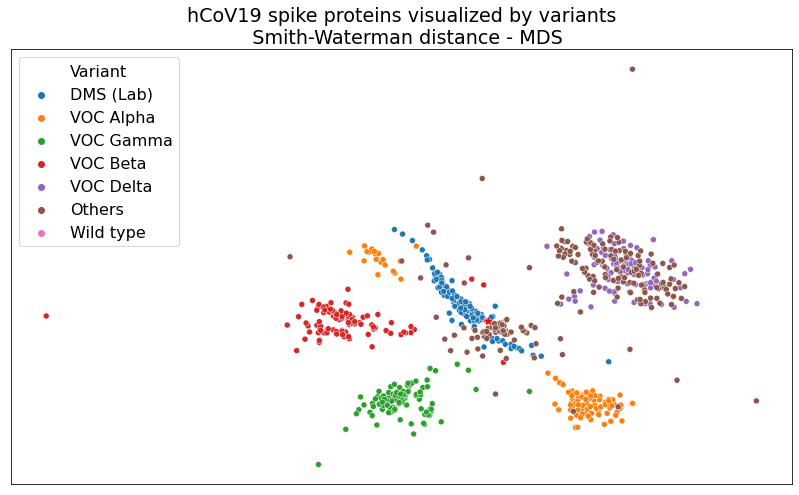

In [10]:
plt.figure(figsize=(14, 8))
sns.set_palette(sns.color_palette("tab10"))
plot = sns.scatterplot(x=xy_mds[:, 0], y=xy_mds[:, 1], hue=df['Variant'])
plt.title("hCoV19 spike proteins visualized by variants\n  Smith-Waterman distance - MDS")
plt.scatter(x=xy_mds[-1, 0], y=xy_mds[-1, 1], marker='*', c='r', s=50)
plt.xticks([])
plt.yticks([])
print(df['Variant'].iloc[-1])
plt.savefig("MDS_tiff.eps", dpi=300)

([], [])

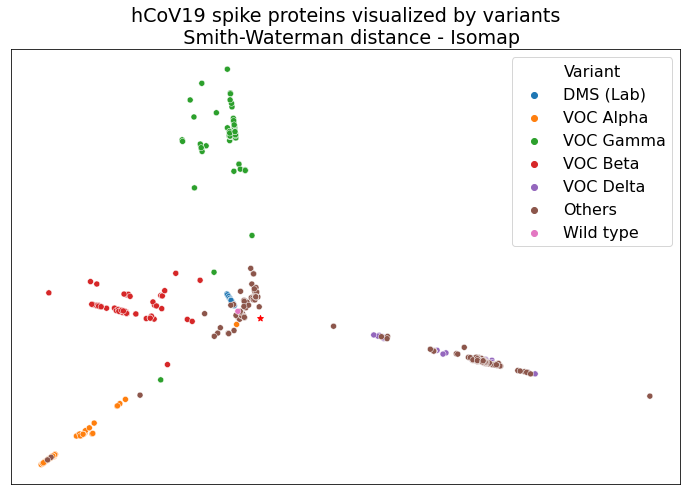

In [11]:
plt.figure(figsize=(12, 8))
sns.set_palette(sns.color_palette("tab10"))
plot = sns.scatterplot(x=xy_iso[:, 0], y=xy_iso[:, 1], hue=df['Variant'])
plt.title("hCoV19 spike proteins visualized by variants\n  Smith-Waterman distance - Isomap")
plt.scatter(x=xy_mds[-1, 0], y=xy_mds[-1, 1], marker='*', c='r')
plt.xticks([])
plt.yticks([])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


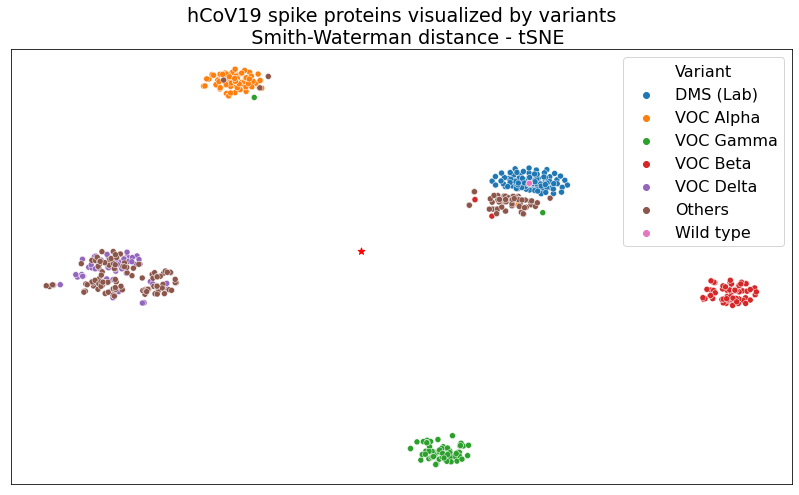

In [12]:
plt.figure(figsize=(14, 8))
sns.set_palette(sns.color_palette("tab10"))
plot = sns.scatterplot(x=xy_tsne[:, 0], y=xy_tsne[:, 1], hue=df['Variant'])
plt.title("hCoV19 spike proteins visualized by variants\n  Smith-Waterman distance - tSNE")
plt.scatter(x=xy_mds[-1, 0], y=xy_mds[-1, 1], marker='*', c='r', s=50)
plt.xticks([])
plt.yticks([])
plt.savefig("tSNE_tiff.eps", dpi=300)

([], [])

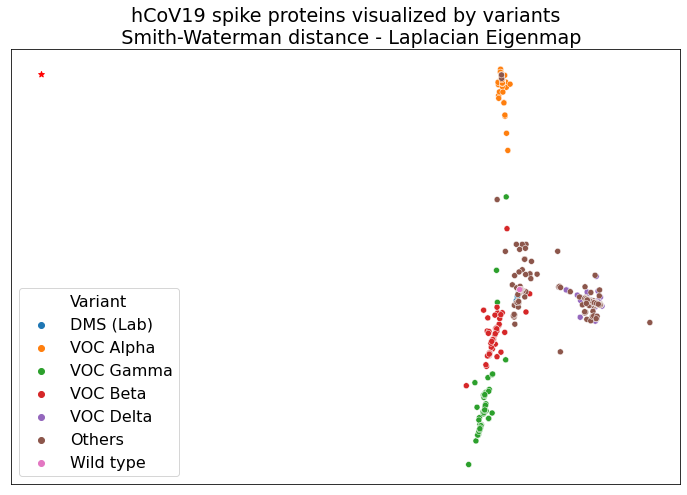

In [13]:
plt.figure(figsize=(12, 8))
sns.set_palette(sns.color_palette("tab10"))
plot = sns.scatterplot(x=xy_LE[:, 0], y=xy_LE[:, 1], hue=df['Variant'])
plt.title("hCoV19 spike proteins visualized by variants\n  Smith-Waterman distance - Laplacian Eigenmap")
plt.scatter(x=xy_mds[-1, 0], y=xy_mds[-1, 1], marker='*', c='r')
plt.xticks([])
plt.yticks([])

## Visualized by sample collection dates

([], [])

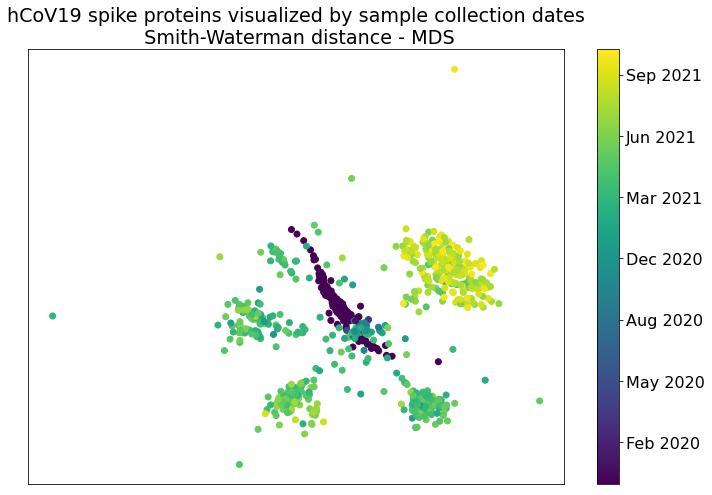

In [14]:
plt.figure(figsize=(12, 8))
plt.scatter(xy_mds[:, 0], xy_mds[:, 1], c=df['Date'])
# sns.set_palette(sns.color_palette("Spectral"))
# plot = sns.scatterplot(x=xy_mds[:, 0], y=xy_mds[:, 1], hue=df['YrMo'])
# h,l = plot.axes.get_legend_handles_labels()
# plot.axes.legend_.remove()
# plot.figure.legend(h,l, ncol=3, bbox_to_anchor=(1.3, 0.8))
plt.title("hCoV19 spike proteins visualized by sample collection dates\n Smith-Waterman distance - MDS")
cbar = plt.colorbar()
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks([])
plt.yticks([])

([], [])

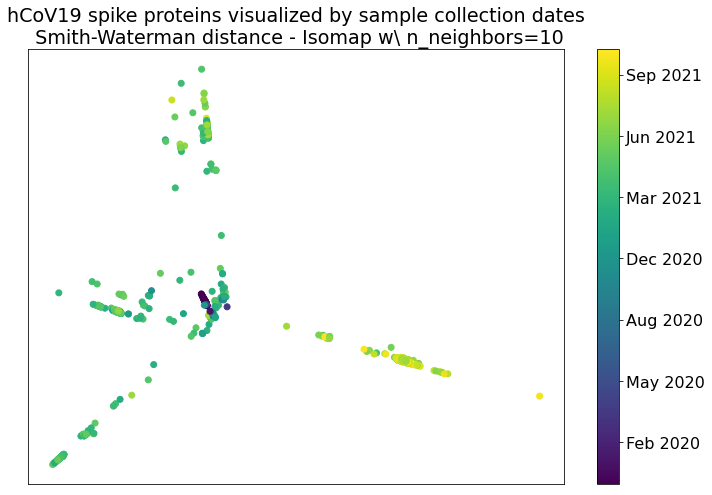

In [15]:
plt.figure(figsize=(12, 8))
plt.scatter(xy_iso[:, 0], xy_iso[:, 1], c=df['Date'])

# sns.set_palette(sns.color_palette("Spectral"))
# plot = sns.scatterplot(x=xy_iso[:, 0], y=xy_iso[:, 1], hue=df['YrMo'])
# h,l = plot.axes.get_legend_handles_labels()
# plot.axes.legend_.remove()
# plot.figure.legend(h,l, ncol=3, bbox_to_anchor=(1.3, 0.8))
plt.title("hCoV19 spike proteins visualized by sample collection dates\n Smith-Waterman distance - Isomap w\ n_neighbors=10")
cbar = plt.colorbar()
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks([])
plt.yticks([])

([], [])

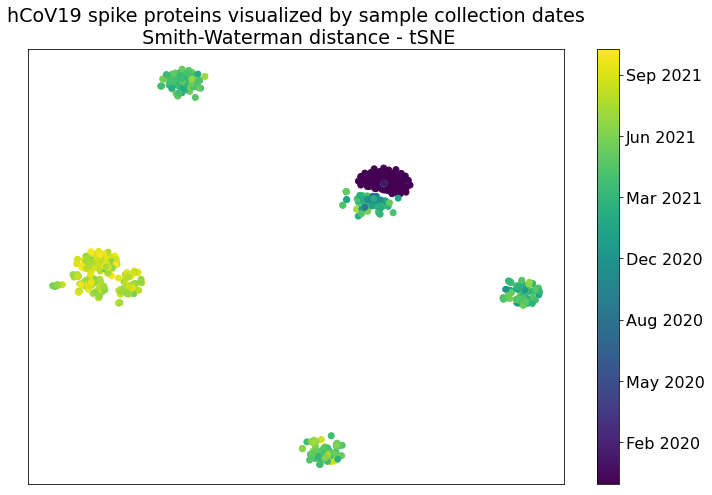

In [16]:
plt.figure(figsize=(12, 8))
plt.scatter(xy_tsne[:, 0], xy_tsne[:, 1], c=df['Date'])
# sns.set_palette(sns.color_palette("Spectral"))
# plot = sns.scatterplot(x=xy_tsne[:, 0], y=xy_tsne[:, 1], hue=df['YrMo'])
# h,l = plot.axes.get_legend_handles_labels()
# plot.axes.legend_.remove()
# plot.figure.legend(h,l, ncol=3, bbox_to_anchor=(1.3, 0.8))
plt.title("hCoV19 spike proteins visualized by sample collection dates\n Smith-Waterman distance - tSNE")
cbar = plt.colorbar()
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks([])
plt.yticks([])

([], [])

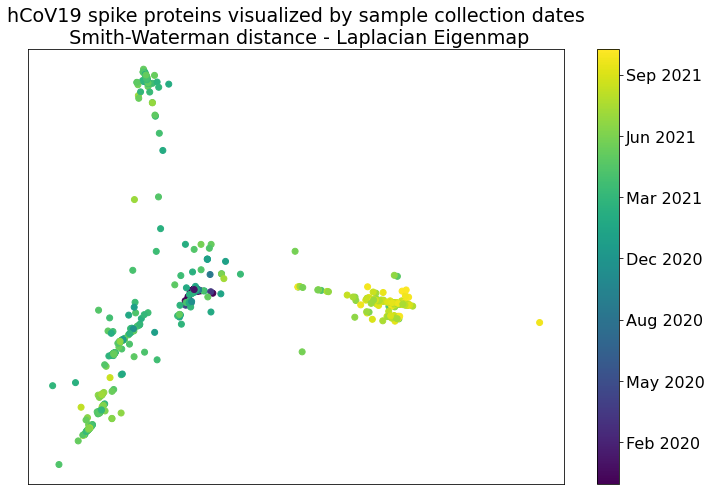

In [17]:
plt.figure(figsize=(12, 8))
plt.scatter(xy_LE[:, 0], xy_LE[:, 1], c=df['Date'])
plt.title("hCoV19 spike proteins visualized by sample collection dates\n Smith-Waterman distance - Laplacian Eigenmap")
cbar = plt.colorbar()
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks([])
plt.yticks([])

## Grouped by continents

([], [])

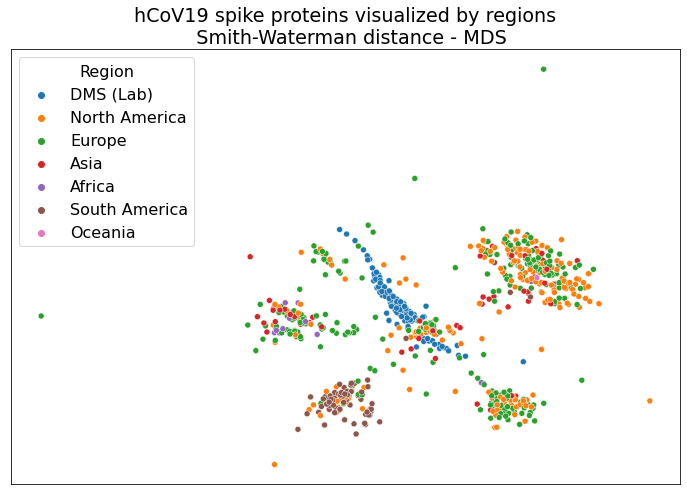

In [18]:
plt.figure(figsize=(12, 8))
sns.set_palette(sns.color_palette("tab10"))
plot = sns.scatterplot(x=xy_mds[:, 0], y=xy_mds[:, 1], hue=df['Region'])
plt.title("hCoV19 spike proteins visualized by regions\n  Smith-Waterman distance - MDS")
plt.xticks([])
plt.yticks([])

([], [])

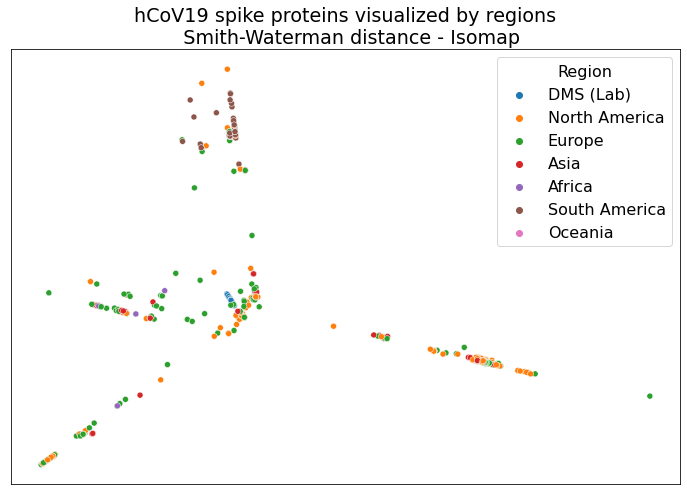

In [19]:
plt.figure(figsize=(12, 8))
sns.set_palette(sns.color_palette("tab10"))
plot = sns.scatterplot(x=xy_iso[:, 0], y=xy_iso[:, 1], hue=df['Region'])
plt.title("hCoV19 spike proteins visualized by regions\n  Smith-Waterman distance - Isomap")
plt.xticks([])
plt.yticks([])

([], [])

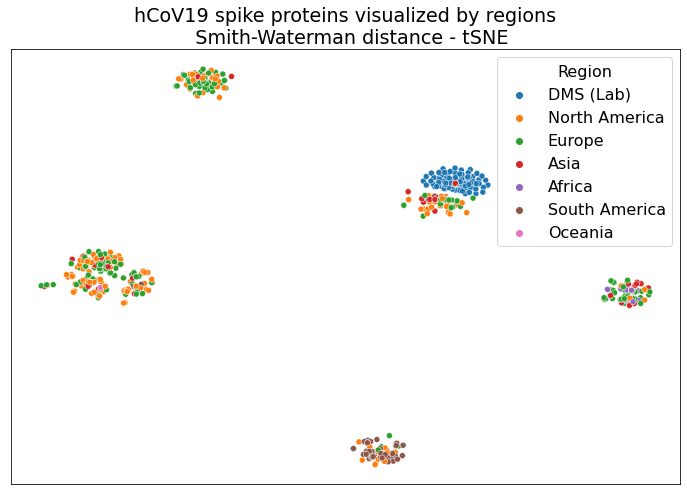

In [20]:
plt.figure(figsize=(12, 8))
sns.set_palette(sns.color_palette("tab10"))
plot = sns.scatterplot(x=xy_tsne[:, 0], y=xy_tsne[:, 1], hue=df['Region'])
plt.title("hCoV19 spike proteins visualized by regions\n  Smith-Waterman distance - tSNE")
plt.xticks([])
plt.yticks([])

([], [])

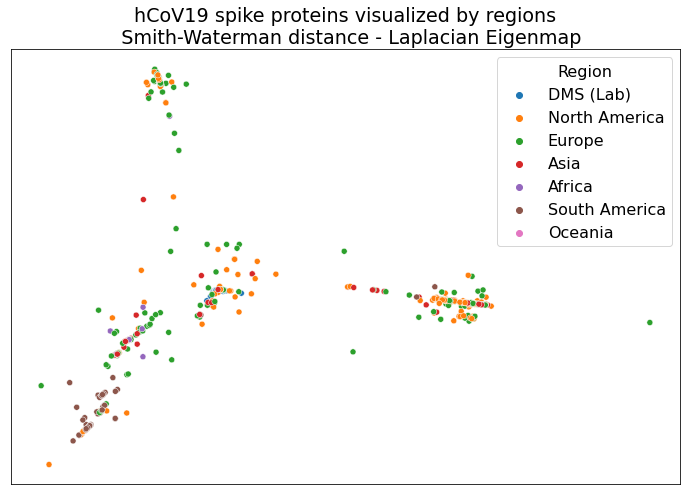

In [21]:
plt.figure(figsize=(12, 8))
sns.set_palette(sns.color_palette("tab10"))
plot = sns.scatterplot(x=xy_LE[:, 0], y=xy_LE[:, 1], hue=df['Region'])
plt.title("hCoV19 spike proteins visualized by regions\n  Smith-Waterman distance - Laplacian Eigenmap")
plt.xticks([])
plt.yticks([])